In [1]:
%load_ext autoreload
%autoreload 2

In [149]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import utility as uty
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng
import json
from django.contrib.auth.models import AnonymousUser

In [27]:
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='Success').count()
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='Fail').count()
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='ToDo').count()

7098
842
0


In [28]:
stkgrpids=list(stkmd.StockGroup.objects.get(GroupName='Sector: Utilities').Symbol.all().values_list('id',flat=True))

In [170]:
Todate=pd.datetime.today().date()
Fromdate=pd.datetime(2002,1,1).date()
stk=stkmd.Stockmeta.objects.get(Symbol='UTIAvg')
df=dtalibs.GetStockData([stk.id],Fromdate,Todate,'concat')
df.head()

 Time for GetStockData =  0.428045034409


,Close,Open,High,Low,Volume,Symbol
Date,,,,,,
2002-01-01,NaN,NaN,NaN,NaN,0,UTIAvg
2002-01-02,32.81,32.41,32.94,31.78,491102,UTIAvg
2002-01-03,32.20,32.26,32.48,31.83,408770,UTIAvg
2002-01-04,32.19,32.17,32.45,31.80,508387,UTIAvg
2002-01-07,32.60,32.49,32.79,32.17,395070,UTIAvg


In [173]:
TUT=set(df.index)-set(T)
TUT

{datetime.date(2002, 1, 1),
 datetime.date(2002, 1, 21),
 datetime.date(2002, 2, 18),
 datetime.date(2002, 3, 29),
 datetime.date(2002, 5, 27),
 datetime.date(2002, 7, 4),
 datetime.date(2002, 9, 2),
 datetime.date(2002, 11, 28),
 datetime.date(2002, 12, 25),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 1, 20),
 datetime.date(2003, 2, 17),
 datetime.date(2003, 4, 18),
 datetime.date(2003, 5, 26),
 datetime.date(2003, 7, 4),
 datetime.date(2003, 9, 1),
 datetime.date(2003, 11, 27),
 datetime.date(2003, 12, 25),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 1, 19),
 datetime.date(2004, 2, 16),
 datetime.date(2004, 4, 9),
 datetime.date(2004, 5, 31),
 datetime.date(2004, 6, 11),
 datetime.date(2004, 7, 5),
 datetime.date(2004, 9, 6),
 datetime.date(2004, 11, 25),
 datetime.date(2004, 12, 24),
 datetime.date(2005, 1, 17),
 datetime.date(2005, 2, 21),
 datetime.date(2005, 3, 25),
 datetime.date(2005, 5, 30),
 datetime.date(2005, 7, 4),
 datetime.date(2005, 9, 5),
 datetime.date(2005,

In [175]:
print(len(df.index))
print (len(df.index.unique()))

4000
4000


In [154]:
stk.LastPriceUpdate=None
stk.save()
print stk.Lastdate,stk.Startdate,stk.LastPriceUpdate

None None None


In [10]:
dtamd.Stockprice.objects.filter(Symbol_id=stk.id)

<QuerySet []>

In [13]:
stkmd.Stockmeta.objects.filter(Derived=True).update(Lastdate=None,Startdate=None,LastPriceUpdate=None)

1

# Add Index

In [143]:
stkmd.IndexComputeCode.objects.first().Code

u'from __future__ import division\nimport utility.models as utmd\n# import stockapp.models as stkmd\n# import dataapp.models as dtamd\nimport dataapp.libs as dtalibs\nimport pandas as pd\n\n\nclass AveragePrice(utmd.index):\n\t"""\n\tTake the average price of all the stocks in the group\n\t"""\n\t\n\tdef __init__(self,*args,**kwargs):\n\t\tsuper(AveragePrice,self).__init__(*args,**kwargs)\n\n\t\tself.register(description="Average Close of Group",name="AverageClose",label="AvgClose",resulttype=pd.DataFrame,\n\t\t\t\t\t\tscale=[\'absolute\',\'%\'],operations=[\'<\',\'>\',\'<=\',\'>=\',\'!=\',\'between\'],computefeatures=True)\n\t\tself.register(description="Volume Average Close of Group",name="VolAvgClose",label="VolAvgClose",resulttype=pd.DataFrame,\n\t\t\t\t\t\tscale=[\'absolute\',\'%\'],operations=[\'<\',\'>\',\'<=\',\'>=\',\'!=\',\'between\'],computefeatures=True)\n\t\t\n\n\tdef compute(self,*args,**kwargs):\n\t\tFromdate=kwargs.get(\'Fromdate\',pd.datetime(2002,1,1).date() )\n\t\tTo

In [ ]:
dtalibs.GetStockData([2,3,4,5],)

# Building Query

In [67]:
url='http://ec2-54-183-21-11.us-west-1.compute.amazonaws.com:8080/?symbols=TSLA,MSFT,AAPL&from=2012-01-01&to=2017-01-01'
import urllib2
response = urllib2.urlopen(url)
html = response.read()
D=json.loads(html)

In [137]:
D['query']

{u'from': u'2012-01-01',
 u'symbols': [u'TSLA', u'MSFT', u'AAPL'],
 u'to': u'2017-01-01'}

In [68]:
print len(D['result'])
# pd.DataFrame(D['result'])
df=pd.DataFrame()
for d in D['result']:
    df=pd.concat([df,pd.DataFrame(d['quotes'])])
df['date']=df['date'].apply(lambda x : pd.to_datetime(x))
df

3


,adjClose,avgVolume,cci5,cci50,close,date,ema8,hasCherries,high,low,...,macdHistogram,macdSignal,open,rsi14,sma20,sma50,snapback,stddev20,symbol,volume
0,28.080000,NaN,NaN,NaN,28.080000,2012-01-03 05:00:00,NaN,None,29.500000,27.650000,...,NaN,NaN,28.940001,NaN,NaN,NaN,NaN,NaN,TSLA,928100
1,27.709999,NaN,NaN,NaN,27.709999,2012-01-04 05:00:00,NaN,None,28.670000,27.500000,...,NaN,NaN,28.209999,NaN,NaN,NaN,NaN,NaN,TSLA,630100
2,27.120001,NaN,NaN,NaN,27.120001,2012-01-05 05:00:00,NaN,None,27.930000,26.850000,...,NaN,NaN,27.760000,NaN,NaN,NaN,NaN,NaN,TSLA,1005500
3,26.910000,NaN,NaN,NaN,26.910000,2012-01-06 05:00:00,NaN,None,27.790001,26.410000,...,NaN,NaN,27.200001,NaN,NaN,NaN,NaN,NaN,TSLA,986300
4,27.250000,NaN,-73.847209,NaN,27.250000,2012-01-09 05:00:00,NaN,None,27.490000,26.120001,...,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,TSLA,897000
5,27.620001,NaN,39.157526,NaN,27.620001,2012-01-10 05:00:00,NaN,None,27.760000,27.250000,...,NaN,NaN,27.440001,NaN,NaN,NaN,NaN,NaN,TSLA,671800
6,28.230000,NaN,128.226640,NaN,28.230000,2012-01-11 05:00:00,NaN,None,28.379999,27.299999,...,NaN,NaN,27.620001,NaN,NaN,NaN,NaN,NaN,TSLA,672300
7,28.250000,NaN,102.695699,NaN,28.250000,2012-01-12 05:00:00,27.646250,None,28.620001,27.809999,...,NaN,NaN,28.480000,NaN,NaN,NaN,NaN,NaN,TSLA,729300
8,22.790001,NaN,-159.180478,NaN,22.790001,2012-01-13 05:00:00,26.567084,None,28.500000,22.639999,...,NaN,NaN,28.400000,NaN,NaN,NaN,NaN,NaN,TSLA,5500400
9,26.600000,NaN,-15.782825,NaN,26.600000,2012-01-17 05:00:00,26.574398,None,27.340000,26.410000,...,NaN,NaN,26.620001,NaN,NaN,NaN,NaN,NaN,TSLA,4651600


In [131]:
print df.columns


Index([u'adjClose', u'avgVolume', u'cci5', u'cci50', u'close', u'date',
       u'ema8', u'hasCherries', u'high', u'low', u'macd', u'macdHistogram',
       u'macdSignal', u'open', u'rsi14', u'sma20', u'sma50', u'snapback',
       u'stddev20', u'symbol', u'volume'],
      dtype='object')


In [111]:
[pd.to_datetime(f) for f in kmeans.cluster_centers_.reshape(1,-1)[0]]

[Timestamp('2014-05-31 14:17:08.571428608'),
 Timestamp('2013-03-18 04:00:00'),
 Timestamp('2014-12-24 21:00:00'),
 Timestamp('2013-10-14 04:08:34.285714176'),
 Timestamp('2012-08-17 10:00:00'),
 Timestamp('2014-09-25 20:00:00'),
 Timestamp('2014-03-18 10:32:43.636363520'),
 Timestamp('2013-08-14 16:00:00'),
 Timestamp('2014-10-28 15:10:54.545454592'),
 Timestamp('2014-08-22 16:00:00'),
 Timestamp('2013-06-17 00:00:00'),
 Timestamp('2014-01-09 23:00:00'),
 Timestamp('2012-10-04 18:24:00'),
 Timestamp('2012-07-08 00:00:00'),
 Timestamp('2014-04-25 14:54:32.727272704'),
 Timestamp('2013-09-13 21:08:34.285714176'),
 Timestamp('2012-12-29 17:00:00'),
 Timestamp('2014-07-17 07:00:00'),
 Timestamp('2013-07-19 10:00:00'),
 Timestamp('2014-11-23 11:51:25.714285824')]

In [127]:
def sequentialcluster(dp):
    dp.index=range(len(dp))
    C=[]
    c=[]
    for i in dp.index[1:]:
        if (dp.loc[i,'date']-dp.loc[i-1,'date']).days<=5:
                c.append(dp.loc[i-1,'date'])
        else:
            C.append(c)
            c=[]
    
    C=[c[int(len(c)/2)] for c in C if len(c)>0]
    return dp[dp['date'].isin(C)]
C=sequentialcluster(dbsma20)


,adjClose,avgVolume,cci5,cci50,close,date,ema8,hasCherries,high,low,...,macdHistogram,macdSignal,open,rsi14,sma20,sma50,snapback,stddev20,symbol,volume
2,31.270000,1331510.0,111.321521,34.130235,31.270000,2012-07-10 04:00:00,31.273066,False,32.480000,30.889999,...,-0.069409,0.218289,31.540001,50.768166,31.392000,30.785600,-77.191285,2.436281,TSLA,758400
4,32.150002,1589725.0,-79.096812,68.627097,32.150002,2012-07-18 04:00:00,32.899272,False,33.669998,31.059999,...,0.170360,0.478699,31.420000,50.873204,32.255000,30.831800,147.723909,2.735942,TSLA,2881900
7,29.940001,1710785.0,58.461867,-29.174704,29.940001,2012-08-10 04:00:00,29.016885,False,29.940001,29.309999,...,0.178617,-0.789518,29.309999,51.005907,29.698000,30.431000,-87.636571,4.854682,TSLA,707400
11,29.160000,1708975.0,88.435338,11.850939,29.160000,2012-10-01 04:00:00,29.157732,False,29.889999,29.000000,...,-0.117403,0.028805,29.500000,49.062091,29.297000,29.116600,-76.584398,2.867362,TSLA,884400
20,97.730003,13695565.0,-15.638260,85.040506,97.730003,2013-06-12 04:00:00,97.447113,False,100.480003,95.750000,...,-1.752110,9.686229,96.800003,60.329446,95.764000,69.882600,100.678765,12.571634,TSLA,9192700
23,99.550003,11863570.0,-151.604751,70.034876,99.550003,2013-06-21 04:00:00,100.664719,True,103.699997,97.500000,...,-1.325519,7.324376,103.699997,58.254844,99.907000,78.216400,221.639627,8.463713,TSLA,11718600
26,119.029999,10552470.0,-21.836794,105.299225,119.029999,2013-07-18 04:00:00,119.833039,False,122.730003,116.180000,...,-0.991784,7.447657,120.970001,56.502715,114.759000,101.844000,127.136018,18.617235,TSLA,11398100
29,139.360001,10327845.0,-114.637521,104.892635,139.360001,2013-08-14 04:00:00,143.092985,True,144.839996,138.050003,...,-0.098776,8.210659,142.720001,55.980246,134.646999,119.297000,219.530156,21.146964,TSLA,11693800
34,165.539993,10392245.0,52.009401,91.704329,165.539993,2013-09-13 04:00:00,165.131411,False,166.369995,162.160004,...,-1.405863,8.271955,162.770004,61.145003,161.676998,143.312798,39.694929,16.959581,TSLA,5401200
43,172.929993,10663450.0,-50.562374,45.583701,172.929993,2013-10-10 04:00:00,176.973002,False,175.750000,169.690002,...,-2.676913,6.163546,173.089996,49.126908,178.760999,164.322998,96.146075,17.825996,TSLA,8883900


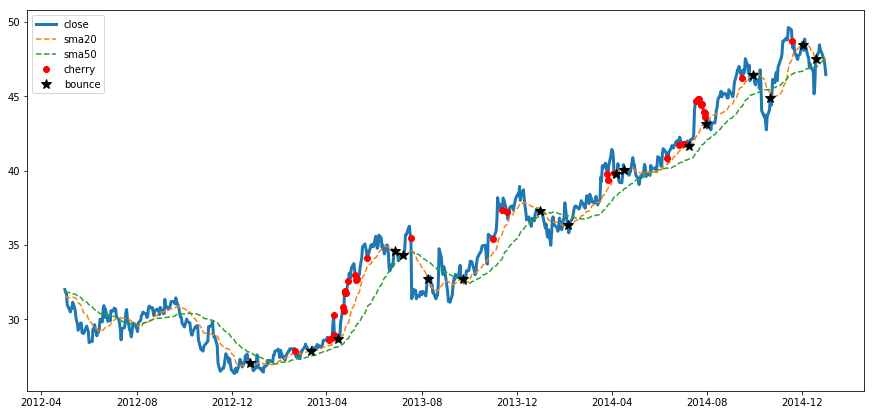

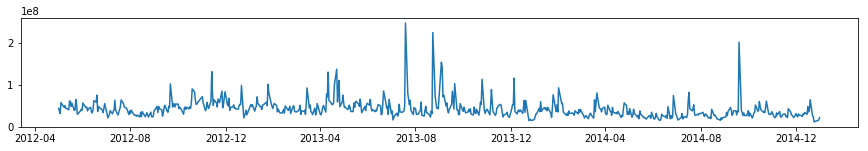

In [139]:

dp=df[(df['symbol']=='MSFT') & (df['date']<pd.datetime(2015,1,1)) & (df['date']>pd.datetime(2012,5,1))]
dc=dp[(dp['hasCherries']==True) & (dp['cci50']>100)]
dbsma20=dp[abs(dp['close']-dp['sma20'])/dp['sma20']< 0.003*dp['stddev20']]
# kmeans = KMeans(n_clusters=30, random_state=0).fit(dbsma20['date'].values.reshape(-1,1))
# dateclusters=[pd.to_datetime(f) for f in kmeans.cluster_centers_.reshape(1,-1)[0]]

dC=sequentialcluster(dbsma20)

fig,ax=plt.subplots(1,1,figsize=(15,7))
ax.plot(dp['date'],dp['close'],linewidth=3,label='close')
ax.plot(dp['date'],dp['sma20'],'--',label='sma20')
ax.plot(dp['date'],dp['sma50'],'--',label='sma50')
# ax.plot(dp['date'],dp['sma20']+0.5*dp['stddev20'],'k--',label='+std20')
# ax.plot(dp['date'],dp['sma20']-0.5*dp['stddev20'],'k--',label='-std20')
ax.plot(dc['date'],dc['close'],'r',marker='o',linestyle='',label='cherry')
# ax.plot(dbsma20['date'],dbsma20['close'],'g',marker='s',linestyle='',label='bounce')
ax.plot(dC['date'],dC['close'],'k',marker='*',markersize=10,linestyle='',label='bounce')


ax.legend()
fig,ax=plt.subplots(1,1,figsize=(15,2))
ax.plot(dp['date'],dp['volume'])
plt.show()